In [ ]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
from tqdm import tqdm

In [ ]:
def get_nk_playlist_data(n = 10, stagger = 0):

    combined_data = []
    progress_bar = tqdm(total = n, desc = "Progress", ncols = 100)

    for i in range(n):
        i1 = stagger + i * 1000
        i2 = stagger + i * 1000 + 999
        filename = "Dataset/spotify_million_playlist_dataset/data/mpd.slice." + str(i1) + "-" + str(i2) + ".json"
        data = json.load(open(filename))
        for playlist in data["playlists"]:
            combined_data.append(playlist)
        progress_bar.update(1)
    progress_bar.close()

    return combined_data

In [ ]:
# Return a new dictionary with the keys typecasted as str
def convert_keys_to_str(D):
    return {str(k): v for k, v in D.items()}

# Return a new dictionary with the keys typecasted back to the original data type
def convert_keys_to_original(D):
    return {eval(k): v for k, v in D.items()}

In [ ]:
TRAIN_N_K = 10
train_data = get_nk_playlist_data(n = TRAIN_N_K)

Progress: 100%|█████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.07it/s]


In [ ]:
# Create a tracks dictionary and co-occurrence sparse matrix using the training data

tracks_dict = {}
tracks_fq = {}
co_occurrence = {}
idx = 1

progress_bar = tqdm(total = len(train_data), desc = "Progress", ncols = 100)

for playlist in train_data:

    increment_value = 1
    # increment_value = playlist['num_followers'] # Uncomment to weigh co-occurrences by number of playlist followers

    playlist_track_ids = []
    for track in playlist['tracks']:
        if track['track_uri'] not in tracks_dict:
            tracks_dict[track['track_uri']] = idx
            tracks_fq[idx] = 1
            idx += 1
        else:
            tracks_fq[tracks_dict[track['track_uri']]] += 1
        playlist_track_ids.append(tracks_dict[track['track_uri']])

    for i in range(len(playlist_track_ids)):
        for j in range(i + 1, len(playlist_track_ids)):
            id_i = playlist_track_ids[i]
            id_j = playlist_track_ids[j]

            if id_i not in co_occurrence:
                co_occurrence[id_i] = {id_j: increment_value}
            elif id_j not in co_occurrence[id_i]:
                co_occurrence[id_i][id_j] = increment_value
            else:
                co_occurrence[id_i][id_j] += increment_value

            if id_j not in co_occurrence:
                co_occurrence[id_j] = {id_i: increment_value}
            elif id_i not in co_occurrence[id_j]:
                co_occurrence[id_j][id_i] = increment_value
            else:
                co_occurrence[id_j][id_i] += increment_value

    progress_bar.update(1)
progress_bar.close()

tracks_fq = dict(sorted(tracks_fq.items(), key=lambda item: item[1], reverse=True))
reverse_tracks_dict = {v: k for k, v in tracks_dict.items()}
top_500_tracks = list(tracks_fq.keys())[: 500]

Progress: 100%|██████████████████████████████████████████████| 10000/10000 [00:31<00:00, 312.66it/s]


In [ ]:
# # Save the co-occurrence matrix
# pickle.dump(co_occurrence, open("co_occurrence_" + str(TRAIN_N_K) + "k.pkl", 'wb'))

In [ ]:
print("Number of unique tracks in training data: " + str(len(tracks_dict)))

Number of unique tracks in training data: 170089


# Random Test Dataset

In [ ]:
test_data = get_nk_playlist_data(n = 10, stagger = 900000)

Progress: 100%|█████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.53it/s]


In [ ]:
# Create test data with 1000 playlists having 25 tracks provided

TEST_SIZE = 1000
NUM_TRACKS_X = 25

test_tracks_x = []
test_tracks_y = []
count = 0

progress_bar = tqdm(total = TEST_SIZE, desc = "Progress", ncols = 100)

for playlist in test_data:

    if playlist['num_tracks'] > NUM_TRACKS_X:
        x_pos_set = set(random.sample(range(playlist['num_tracks']), NUM_TRACKS_X))
        x_list = []
        y_list = []

        for i in range(playlist['num_tracks']):
            track = playlist['tracks'][i]
            if i in x_pos_set:
                # Only accounting for the tracks in our training data - might lead to less than 25 tracks
                if track['track_uri'] in tracks_dict:
                    track_id = tracks_dict[track['track_uri']]
                    x_list.append(track_id)
            else:
                if track['track_uri'] in tracks_dict:
                    track_id = tracks_dict[track['track_uri']]
                    y_list.append(track_id)
                else:
                    y_list.append(0)
        test_tracks_x.append(x_list)
        test_tracks_y.append(y_list)

        count += 1
        progress_bar.update(1)
        if count >= TEST_SIZE:
            break

progress_bar.close()

Progress: 100%|██████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10085.73it/s]


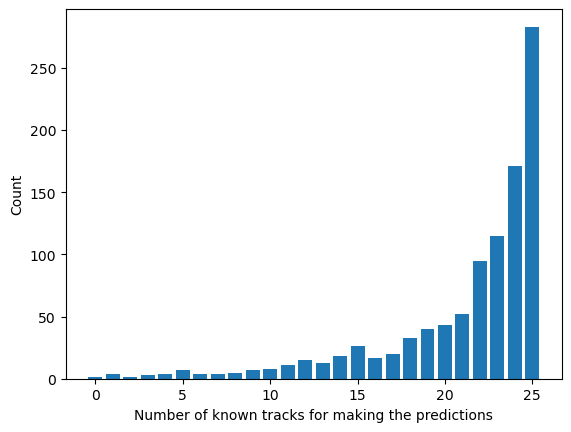

In [ ]:
# Get statistics of number of known tracks out of 25 for each test playlist

D = {}
for i in range(len(test_tracks_x)):
    num_tracks_x = len(test_tracks_x[i])
    if num_tracks_x not in D:
        D[num_tracks_x] = 1
    else:
        D[num_tracks_x] += 1
sorted_items = sorted(D.items(), key = lambda item: item[0], reverse = True)
x_values = [item[0] for item in sorted_items]
y_values = [item[1] for item in sorted_items]
plt.bar(x_values, y_values)
plt.xlabel('Number of known tracks for making the predictions')
plt.ylabel('Count')
plt.show()

In [ ]:
# # Load the stored co-occurrence matrix
# co_occurrence = pickle.load(open("co_occurrence_100k.pkl", 'rb'))

In [ ]:
# Make predictions

test_tracks_y_pred = []

progress_bar = tqdm(total = len(test_tracks_x), desc = "Progress", ncols = 100)

for i in range(len(test_tracks_x)):
    x_list = test_tracks_x[i]
    x_set = set(x_list)
    pred_dict = {}
    for id_i in x_list:
        for id_j in co_occurrence[id_i]:
            if id_j not in x_set:
                if id_j not in pred_dict:
                    pred_dict[id_j] = co_occurrence[id_i][id_j]
                else:
                    pred_dict[id_j] += co_occurrence[id_i][id_j]
    sorted_recs = sorted(pred_dict.items(), key = lambda item: item[1], reverse = True)
    top_500_recs = [item[0] for item in sorted_recs[: 500]]

    top_idx = 0
    while len(top_500_recs) < 500:
        if top_500_tracks[top_idx] not in top_500_recs:
            top_500_recs.append(top_500_tracks[top_idx])
        top_idx += 1

    test_tracks_y_pred.append(top_500_recs)

    progress_bar.update(1)
progress_bar.close()

Progress: 100%|█████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.46it/s]


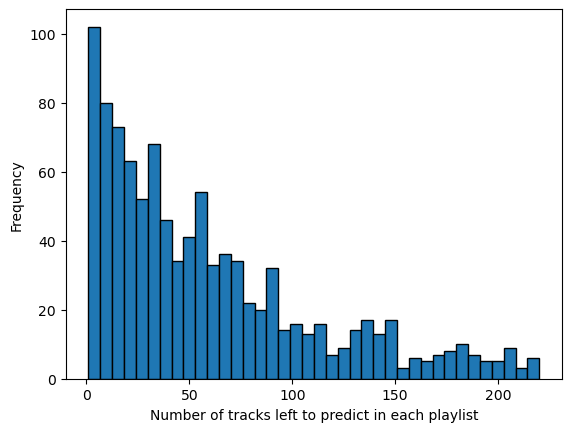

Total number of tracks to predict: 59185
Average number of tracks to predict per playlist: 59.185


In [ ]:
# Get statistics of number of tracks for each test playlist

D2 = {}
total_count = 0

for i in range(len(test_tracks_y)):
    num_tracks_y_pred = len(test_tracks_y[i])
    if num_tracks_y_pred not in D2:
        D2[num_tracks_y_pred] = 1
    else:
        D2[num_tracks_y_pred] += 1
    total_count += num_tracks_y_pred
sorted_items = sorted(D2.items(), key = lambda item: item[0], reverse = True)
x_values = [item[0] for item in sorted_items]
y_values = [item[1] for item in sorted_items]
plt.hist(x_values, weights = y_values, bins = len(x_values) // 5, edgecolor = 'black')
plt.xlabel('Number of tracks left to predict in each playlist')
plt.ylabel('Frequency')
plt.show()
print("Total number of tracks to predict: " + str(total_count))
print("Average number of tracks to predict per playlist: " + str(total_count / TEST_SIZE))

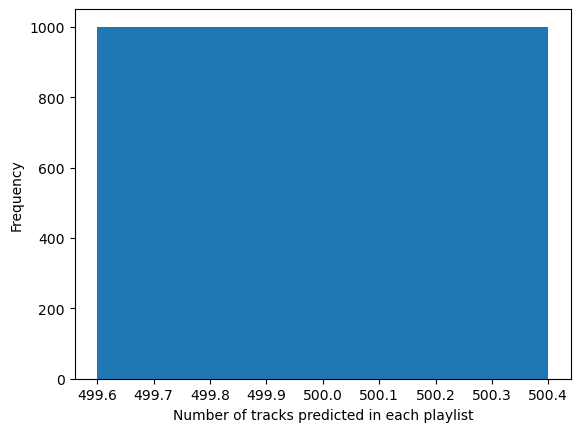

[(500, 1000)]


In [ ]:
# Get statistics of number of predicted tracks for each test playlist

D2 = {}
for i in range(len(test_tracks_y_pred)):
    num_tracks_y_pred = len(test_tracks_y_pred[i])
    if num_tracks_y_pred not in D2:
        D2[num_tracks_y_pred] = 1
    else:
        D2[num_tracks_y_pred] += 1
sorted_items = sorted(D2.items(), key = lambda item: item[0], reverse = True)
x_values = [item[0] for item in sorted_items]
y_values = [item[1] for item in sorted_items]
plt.bar(x_values, y_values)
plt.xlabel('Number of tracks predicted in each playlist')
plt.ylabel('Frequency')
plt.show()
print(sorted_items)

In [ ]:
def r_precision(G, S):
    if len(G) == 0:
        return 0
    intersection = set(S) & set(G)
    return len(intersection) / len(G)

In [ ]:
print(len(test_tracks_y))

1000


In [ ]:
# Get the R-precision score

total_r_precision = 0

for i in range(len(test_tracks_y)):
    total_r_precision += r_precision(test_tracks_y[i], test_tracks_y_pred[i])

avg_r_precision = total_r_precision / len(test_tracks_y)

print(avg_r_precision)

0.41385653458163413


In [ ]:
idx = 0

print(test_tracks_y[idx])
print(test_tracks_y_pred[idx])
print(set(test_tracks_y[idx]) & set(test_tracks_y_pred[idx]))
print(r_precision(test_tracks_y[idx], test_tracks_y_pred[idx]))

[558, 530, 120296, 23746, 11811, 7521, 1244, 1248, 50863, 4835, 24559]
[1336, 2699, 2716, 1160, 1338, 2701, 2702, 4639, 4773, 8930, 5267, 4833, 4838, 1335, 6580, 4812, 1348, 10343, 512, 554, 1410, 4835, 552, 2784, 4754, 4768, 4215, 7522, 8441, 533, 5980, 3512, 7525, 1379, 1396, 1316, 3148, 4743, 405, 4756, 10345, 3546, 1926, 537, 3714, 8810, 1373, 8449, 12926, 2706, 2072, 1362, 546, 558, 1401, 1332, 8444, 3152, 1412, 1395, 4822, 5282, 1369, 3544, 8918, 3545, 2081, 4755, 539, 12918, 1364, 8440, 9801, 2707, 9022, 5262, 530, 1890, 9377, 3539, 7526, 1330, 2771, 1415, 3156, 2700, 4778, 9893, 524, 22551, 6884, 13566, 2782, 1387, 542, 4844, 16812, 3508, 4776, 9011, 9034, 10144, 3524, 3334, 3525, 7529, 2779, 6501, 4103, 1953, 4779, 1875, 14442, 6421, 1918, 14422, 514, 3523, 522, 4208, 1366, 16259, 13181, 3528, 3929, 2705, 8995, 4790, 559, 1411, 4792, 19828, 10334, 24555, 6502, 1187, 1333, 5984, 3162, 6074, 2365, 5983, 1350, 12933, 6944, 4816, 4857, 4836, 13165, 5291, 22536, 16820, 564, 11237, 

# Challenge Dataset

In [ ]:
def get_challenge_set_data():

    challenge_data = []

    filename = "Dataset/spotify_million_playlist_dataset_challenge/challenge_set.json"
    data = json.load(open(filename))
    for playlist in data["playlists"]:
        challenge_data.append(playlist)

    return challenge_data

In [ ]:
challenge_data = get_challenge_set_data()

In [ ]:
print((challenge_data[0]))

{'name': 'spanish playlist', 'num_holdouts': 11, 'pid': 1000002, 'num_tracks': 11, 'tracks': [], 'num_samples': 0}


In [ ]:
# Create challenge data with known tracks from training data

CHALLENGE_SIZE = len(challenge_data)

challenge_tracks_x = []
challenge_pids = []
count = 0

progress_bar = tqdm(total = CHALLENGE_SIZE, desc = "Progress", ncols = 100)

for playlist in challenge_data:

        challenge_pids.append(playlist['pid'])
        x_list = []

        for i in range(playlist['num_samples']):
            track = playlist['tracks'][i]
            # Only accounting for the tracks in our training data - might lead to less than given number of tracks
            if track['track_uri'] in tracks_dict:
                track_id = tracks_dict[track['track_uri']]
                x_list.append(track_id)
        challenge_tracks_x.append(x_list)

        progress_bar.update(1)
progress_bar.close()

Progress: 100%|████████████████████████████████████████████| 10000/10000 [00:00<00:00, 41643.95it/s]


In [ ]:
# Make predictions on challenge set

challenge_tracks_y_pred = []

progress_bar = tqdm(total = len(challenge_tracks_x), desc = "Progress", ncols = 100)

for i in range(len(challenge_tracks_x)):
    x_list = challenge_tracks_x[i]
    x_set = set(x_list)
    pred_dict = {}
    for id_i in x_list:
        for id_j in co_occurrence[id_i]:
            if id_j not in x_set:
                if id_j not in pred_dict:
                    pred_dict[id_j] = co_occurrence[id_i][id_j]
                else:
                    pred_dict[id_j] += co_occurrence[id_i][id_j]
    sorted_recs = sorted(pred_dict.items(), key = lambda item: item[1], reverse = True)
    top_500_recs = [item[0] for item in sorted_recs[: 500]]

    top_idx = 0
    while len(top_500_recs) < 500:
        if top_500_tracks[top_idx] not in top_500_recs:
            top_500_recs.append(top_500_tracks[top_idx])
        top_idx += 1

    challenge_tracks_y_pred.append(top_500_recs)

    progress_bar.update(1)
progress_bar.close()

Progress: 100%|███████████████████████████████████████████████| 10000/10000 [05:11<00:00, 32.10it/s]


In [ ]:
# Write to submission file
with open("submission" + str(TRAIN_N_K) + "k.csv", 'w', newline='') as file:
    writer = csv.writer(file)

    # Replace with your team name and id
    team_info_line = ['team_info', 'Team TARDy', 'taejasgu@usc.edu']
    writer.writerow(team_info_line)

    for pid, tracks_list in zip(challenge_pids, challenge_tracks_y_pred):
        tracks_uris = [reverse_tracks_dict[item] for item in tracks_list]
        row = [pid] + tracks_uris
        writer.writerow(row)

In [ ]:
print(len(challenge_pids))

10000


# Stratified Sampling Dataset

In [ ]:
def get_stratified_test_set_data(filename):

    stratified_data = []

    data = json.load(open(filename))
    for playlist in data["playlists"]:
        stratified_data.append(playlist)

    return stratified_data

In [ ]:
unordered_data = get_stratified_test_set_data(filename = "Dataset/test_set_1k_1k_26_90_unordered.json")
ordered_data = get_stratified_test_set_data(filename = "Dataset/test_set_1k_1k_26_90_ordered.json")

In [ ]:
# Stratified sampled data with 1000 playlists having 25 tracks provided

STRATIFIED_SIZE = 1000

unordered_tracks_x = []
ordered_tracks_x = []
stratified_pids = []
count = 0

progress_bar = tqdm(total = STRATIFIED_SIZE, desc = "Progress", ncols = 100)

for playlist in unordered_data:

    stratified_pids.append(playlist['pid'])
    x_list = []

    for i in range(len(playlist['tracks'])):
        track = playlist['tracks'][i]
        # Only accounting for the tracks in our training data - will have at least 23 tracks as THRESHOLD_PERC is 90
        if track['track_uri'] in tracks_dict:
            track_id = tracks_dict[track['track_uri']]
            x_list.append(track_id)
    unordered_tracks_x.append(x_list)

    progress_bar.update(1)
progress_bar.close()

progress_bar = tqdm(total = STRATIFIED_SIZE, desc = "Progress", ncols = 100)

for playlist in ordered_data:

    x_list = []

    for i in range(len(playlist['tracks'])):
        track = playlist['tracks'][i]
        # Only accounting for the tracks in our training data - will have at least 23 tracks as THRESHOLD_PERC is 90
        if track['track_uri'] in tracks_dict:
            track_id = tracks_dict[track['track_uri']]
            x_list.append(track_id)
    ordered_tracks_x.append(x_list)

    progress_bar.update(1)
progress_bar.close()

Progress: 100%|██████████████████████████████████████████████| 1000/1000 [00:00<00:00, 38455.51it/s]


In [ ]:
# Make predictions on stratified sampled set

unordered_tracks_y_pred = []
ordered_tracks_y_pred = []

progress_bar = tqdm(total = len(unordered_tracks_x), desc = "Progress", ncols = 100)

for i in range(len(unordered_tracks_x)):
    x_list = unordered_tracks_x[i]
    x_set = set(x_list)
    pred_dict = {}
    for id_i in x_list:
        for id_j in co_occurrence[id_i]:
            if id_j not in x_set:
                if id_j not in pred_dict:
                    pred_dict[id_j] = co_occurrence[id_i][id_j]
                else:
                    pred_dict[id_j] += co_occurrence[id_i][id_j]
    sorted_recs = sorted(pred_dict.items(), key = lambda item: item[1], reverse = True)
    top_500_recs = [item[0] for item in sorted_recs[: 500]]

    top_idx = 0
    while len(top_500_recs) < 500:
        if top_500_tracks[top_idx] not in top_500_recs:
            top_500_recs.append(top_500_tracks[top_idx])
        top_idx += 1

    unordered_tracks_y_pred.append(top_500_recs)

    progress_bar.update(1)
progress_bar.close()

progress_bar = tqdm(total = len(unordered_tracks_x), desc = "Progress", ncols = 100)

for i in range(len(ordered_tracks_x)):
    x_list = ordered_tracks_x[i]
    x_set = set(x_list)
    pred_dict = {}
    for id_i in x_list:
        for id_j in co_occurrence[id_i]:
            if id_j not in x_set:
                if id_j not in pred_dict:
                    pred_dict[id_j] = co_occurrence[id_i][id_j]
                else:
                    pred_dict[id_j] += co_occurrence[id_i][id_j]
    sorted_recs = sorted(pred_dict.items(), key = lambda item: item[1], reverse = True)
    top_500_recs = [item[0] for item in sorted_recs[: 500]]

    top_idx = 0
    while len(top_500_recs) < 500:
        if top_500_tracks[top_idx] not in top_500_recs:
            top_500_recs.append(top_500_tracks[top_idx])
        top_idx += 1

    ordered_tracks_y_pred.append(top_500_recs)

    progress_bar.update(1)
progress_bar.close()

Progress: 100%|█████████████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.31it/s]


In [ ]:
# Write to json

unordered_dict = {}
ordered_dict = {}

unordered_tracks_y_pred_uris = [[reverse_tracks_dict[key] for key in inner_list] for inner_list in unordered_tracks_y_pred]
ordered_tracks_y_pred_uris = [[reverse_tracks_dict[key] for key in inner_list] for inner_list in ordered_tracks_y_pred]

for i in range(len(stratified_pids)):
    unordered_dict[stratified_pids[i]] = unordered_tracks_y_pred_uris[i]
    ordered_dict[stratified_pids[i]] = ordered_tracks_y_pred_uris[i]

with open("pred_1k_1k_26_90_unordered.json", 'w') as pred_file:
    json.dump(unordered_dict, pred_file, indent = 4)
with open("pred_1k_1k_26_90_ordered.json", 'w') as pred_file:
    json.dump(ordered_dict, pred_file, indent = 4)

# Only first track given in test playlist

In [ ]:
def get_stratified_test_set_data(filename):

    stratified_data = []

    data = json.load(open(filename))
    for playlist in data["playlists"]:
        stratified_data.append(playlist)

    return stratified_data

In [ ]:
ordered_data = get_stratified_test_set_data(filename = "Dataset/test_set_10k_1k_2_90_ordered.json")

In [ ]:
# Stratified sampled data with 1000 playlists having a single track provided

STRATIFIED_SIZE = 1000

ordered_tracks_x = []
stratified_pids = []
count = 0

progress_bar = tqdm(total = STRATIFIED_SIZE, desc = "Progress", ncols = 100)

for playlist in ordered_data:

    stratified_pids.append(playlist['pid'])
    x_list = []

    for i in range(len(playlist['tracks'])):
        track = playlist['tracks'][i]
        # Guaranteed to have the track in our training data as THRESHOLD_PERC is 90 with only 1 track
        if track['track_uri'] in tracks_dict:
            track_id = tracks_dict[track['track_uri']]
            x_list.append(track_id)
    ordered_tracks_x.append(x_list)

    progress_bar.update(1)
progress_bar.close()

Progress: 100%|█████████████████████████████████████████████| 1000/1000 [00:00<00:00, 142838.31it/s]


In [ ]:
# Make predictions on stratified sampled set

ordered_tracks_y_pred = []

progress_bar = tqdm(total = len(ordered_tracks_x), desc = "Progress", ncols = 100)

for i in range(len(ordered_tracks_x)):
    x_list = ordered_tracks_x[i]
    x_set = set(x_list)
    pred_dict = {}
    for id_i in x_list:
        for id_j in co_occurrence[id_i]:
            if id_j not in x_set:
                if id_j not in pred_dict:
                    pred_dict[id_j] = co_occurrence[id_i][id_j]
                else:
                    pred_dict[id_j] += co_occurrence[id_i][id_j]
    sorted_recs = sorted(pred_dict.items(), key = lambda item: item[1], reverse = True)
    top_500_recs = [item[0] for item in sorted_recs[: 500]]

    top_idx = 0
    while len(top_500_recs) < 500:
        if top_500_tracks[top_idx] not in top_500_recs:
            top_500_recs.append(top_500_tracks[top_idx])
        top_idx += 1

    ordered_tracks_y_pred.append(top_500_recs)

    progress_bar.update(1)
progress_bar.close()

Progress: 100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 358.57it/s]


In [ ]:
# Write to json

ordered_dict = {}

ordered_tracks_y_pred_uris = [[reverse_tracks_dict[key] for key in inner_list] for inner_list in ordered_tracks_y_pred]

for i in range(len(stratified_pids)):
    ordered_dict[stratified_pids[i]] = ordered_tracks_y_pred_uris[i]

with open("pred_10k_1k_2_90_ordered.json", 'w') as pred_file:
    json.dump(ordered_dict, pred_file, indent = 4)